# MAPS Dataset Exploration: Understanding Spatial Proteomics Data

**Author:** Research Analysis  
**Date:** January 16, 2026  
**Purpose:** Comprehensive exploration and understanding of the spatial proteomics datasets used in MAPS (Machine learning for Analysis of Proteomics in Spatial biology)

---

## Table of Contents
1. [Introduction to Spatial Proteomics](#intro)
2. [Dataset Overview](#overview)
3. [Data Structure & Format](#structure)
4. [Loading the Data](#loading)
5. [Exploratory Data Analysis](#eda)
6. [Cell Types & Markers](#celltypes)
7. [Train/Validation Split Strategy](#split)
8. [Data Statistics & Class Distribution](#stats)
9. [Visualization](#viz)
10. [Key Insights & Challenges](#insights)

---
## 1. Introduction to Spatial Proteomics <a id='intro'></a>

### What is Spatial Proteomics?

Spatial proteomics combines:
- **Proteomics:** Measuring protein expression levels in cells
- **Spatial Context:** Preserving the 2D/3D location of cells in tissue

### Technologies Used in MAPS

#### CODEX (CO-Detection by indEXing)
- Multiplexed imaging technique
- Can measure 40-60+ proteins simultaneously
- Uses cyclic immunofluorescence
- Preserves spatial architecture of tissue

#### MIBI (Multiplexed Ion Beam Imaging)
- Uses ion beam to ablate tissue section
- Measures proteins via mass spectrometry
- High spatial resolution (~260nm)
- Can measure 40+ proteins simultaneously

### Why is This Important?

Traditional methods require manual annotation by pathologists:
- ⏱️ **Time-consuming:** Hours per tissue sample
- 👥 **Expert-dependent:** Requires trained pathologists
- 📊 **Not scalable:** Can't handle large datasets
- 🔄 **Inconsistent:** Inter-observer variability

**MAPS Solution:** Automated cell type classification with pathologist-level accuracy!

---
## 2. Dataset Overview <a id='overview'></a>

The MAPS paper evaluates performance on multiple datasets:

| Dataset | Technology | Disease | Tissue | # Markers | # Cells | # Cell Types |
|---------|-----------|---------|--------|-----------|---------|-------------|
| **cHL CODEX** | CODEX | Hodgkin Lymphoma | Lymph Node | 54 | ~100K+ | 12 |
| **cHL1 MIBI** | MIBI | EBV+ Hodgkin Lymphoma | Lymph Node | 36 | ~50K+ | 12 |
| **cHL2 MIBI** | MIBI | Hodgkin Lymphoma | Lymph Node | 36 | ~50K+ | 12 |
| **DLBC MIBI** | MIBI | Diffuse Large B-Cell Lymphoma | Lymph Node | 36 | ~40K+ | 10 |
| **CRC CODEX** | CODEX | Colorectal Cancer | Colon | 47 | ~80K+ | 11 |

### Dataset Highlights
- **Multi-technology:** Both CODEX and MIBI imaging
- **Multiple diseases:** Different types of lymphomas and cancer
- **Expert annotations:** All cells manually labeled by pathologists
- **Cross-validation:** 5-fold stratified cross-validation used
- **Generalization tests:** Cross-dataset evaluation (e.g., train on cHL1, test on cHL2)

In [9]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")
print(f"  - NumPy version: {np.__version__}")
print(f"  - Pandas version: {pd.__version__}")

✓ Libraries imported successfully!
  - NumPy version: 2.3.3
  - Pandas version: 2.3.3


---
## 3. Data Structure & Format <a id='structure'></a>

### File Organization

```
MAPS/
├── data/
│   └── cell_phenotyping/
│       ├── train.csv          # Training data
│       └── valid.csv          # Validation data
├── cHL_CODEX/
│   ├── annotation_csv/        # Ground truth annotations
│   ├── raw_image/             # Original microscopy images
│   └── segmentation/          # Cell segmentation masks
└── models/
    └── cell_phenotyping/
        └── cHL_CODEX.pt       # Pre-trained model weights
```

### CSV Data Format

Each row represents a **single cell** with:
- **Protein Marker Columns:** Expression levels for each protein (e.g., CD3, CD20, CD45, etc.)
- **cell_label:** Ground truth cell type (integer encoded)

Example structure:
```
| Marker_1 | Marker_2 | ... | Marker_47 | cell_label |
|----------|----------|-----|-----------|------------|
|   145.2  |   23.4   | ... |   198.7   |     3      |
|    89.1  |  201.5   | ... |    45.3   |     7      |
```

### Data Preprocessing Pipeline

1. **Segmentation:** Identify individual cells in tissue images
2. **Feature Extraction:** Measure mean protein intensity per cell
3. **Normalization:** Z-score normalization (mean=0, std=1)
4. **Scaling:** Divide by 255 to get values in [0, 1] range
5. **Annotation:** Expert pathologist labels each cell type

---
## 4. Loading the Data <a id='loading'></a>

Let's load and inspect the actual dataset used for training.

In [10]:
# Define paths
base_path = Path(r"c:\Users\mahee\OneDrive\Documents\Semester-12\FYDP-2\MAPS")
train_path = base_path / "data" / "cell_phenotyping" / "train.csv"
valid_path = base_path / "data" / "cell_phenotyping" / "valid.csv"

# Check if files exist
print("Checking data files...")
print(f"  Train file exists: {train_path.exists()}")
print(f"  Valid file exists: {valid_path.exists()}")

if train_path.exists():
    print(f"\n  Train file size: {train_path.stat().st_size / (1024**2):.2f} MB")
if valid_path.exists():
    print(f"  Valid file size: {valid_path.stat().st_size / (1024**2):.2f} MB")

Checking data files...
  Train file exists: True
  Valid file exists: True

  Train file size: 88.68 MB
  Valid file size: 22.17 MB


In [11]:
# Load the datasets
# Note: These files are large (>50MB), so we'll use chunking if needed

print("Loading training data...")
try:
    # Try to load a sample first to understand structure
    train_sample = pd.read_csv(train_path, nrows=1000)
    print(f"✓ Successfully loaded sample of training data")
    print(f"  Shape: {train_sample.shape}")
    print(f"  Columns: {len(train_sample.columns)}")
except Exception as e:
    print(f"⚠ Could not load data: {e}")
    print("  Creating synthetic example data for demonstration...")
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    n_samples = 1000
    n_markers = 47
    n_classes = 12
    
    # Generate random protein expression data
    marker_data = np.random.randn(n_samples, n_markers) * 50 + 100
    labels = np.random.randint(0, n_classes, n_samples)
    
    # Create DataFrame
    marker_cols = [f"Marker_{i+1}" for i in range(n_markers)]
    train_sample = pd.DataFrame(marker_data, columns=marker_cols)
    train_sample['cell_label'] = labels
    
    print(f"✓ Created synthetic dataset")
    print(f"  Shape: {train_sample.shape}")

Loading training data...
✓ Successfully loaded sample of training data
  Shape: (1000, 51)
  Columns: 51


In [12]:
# Display first few rows
print("First 5 rows of the dataset:\n")
display(train_sample.head())

print("\nDataset Info:")
print(f"  Total cells: {len(train_sample):,}")
print(f"  Number of protein markers: {len(train_sample.columns) - 1}")
print(f"  Cell types (unique labels): {train_sample['cell_label'].nunique()}")
print(f"  Memory usage: {train_sample.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

First 5 rows of the dataset:



,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,...,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin,cellSize,cell_label
0,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,...,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827,42,0
1,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,...,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198,63,3
2,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,...,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151,64,10
3,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,...,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000,61,1
4,1.000000,0.640485,0.000089,0.000000,0.000029,0.095688,0.000000,0.010217,0.338147,0.840361,...,0.297199,0.878536,0.079846,0.000871,0.000454,0.136568,0.0,0.014955,60,0



Dataset Info:
  Total cells: 1,000
  Number of protein markers: 50
  Cell types (unique labels): 16
  Memory usage: 0.39 MB


---
## 5. Exploratory Data Analysis <a id='eda'></a>

Let's explore the basic statistics and characteristics of the data.

In [13]:
# Basic statistics
print("=" * 80)
print("BASIC STATISTICS")
print("=" * 80)

# Get marker columns (exclude label)
marker_cols = [col for col in train_sample.columns if col != 'cell_label']

print("\nProtein Expression Statistics:")
stats = train_sample[marker_cols].describe()
display(stats)

print("\nValue Ranges:")
print(f"  Minimum value across all markers: {train_sample[marker_cols].min().min():.2f}")
print(f"  Maximum value across all markers: {train_sample[marker_cols].max().max():.2f}")
print(f"  Mean of all values: {train_sample[marker_cols].values.mean():.2f}")
print(f"  Std of all values: {train_sample[marker_cols].values.std():.2f}")

BASIC STATISTICS

Protein Expression Statistics:


,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,...,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin,cellSize
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.305298,0.325736,0.078539,0.130923,0.047191,0.066837,0.095080,0.042056,0.236376,0.223778,...,0.058253,0.162664,0.348885,0.132016,0.125964,0.121169,0.196905,0.008346,0.127807,307.789000
std,0.281111,0.208782,0.182918,0.210123,0.138631,0.094869,0.182478,0.101154,0.188556,0.289819,...,0.107299,0.128742,0.213809,0.157016,0.185577,0.186141,0.176683,0.082477,0.158950,156.429321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,0.065483,0.158656,0.000000,0.000000,0.000000,0.011558,0.001260,0.004944,0.093800,0.001245,...,0.000193,0.061654,0.173448,0.032119,0.015408,0.001361,0.069560,0.000000,0.032901,197.000000
50%,0.210679,0.312622,0.000089,0.030281,0.000029,0.044399,0.027204,0.013595,0.220656,0.062877,...,0.011385,0.151143,0.336841,0.094255,0.061794,0.046053,0.152315,0.000000,0.076770,294.000000
75%,0.498498,0.467370,0.043767,0.174874,0.023948,0.092687,0.102355,0.031989,0.331678,0.397075,...,0.079696,0.233861,0.514881,0.169073,0.144167,0.160163,0.267189,0.000000,0.155035,395.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.960982,1.000000,0.998391,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1315.000000



Value Ranges:
  Minimum value across all markers: 0.00
  Maximum value across all markers: 1315.00
  Mean of all values: 6.31
  Std of all values: 48.41


In [14]:
# Check for missing values
print("\nMissing Values Check:")
missing = train_sample.isnull().sum()
if missing.sum() == 0:
    print("  ✓ No missing values found!")
else:
    print(f"  ⚠ Found {missing.sum()} missing values:")
    print(missing[missing > 0])


Missing Values Check:
  ✓ No missing values found!


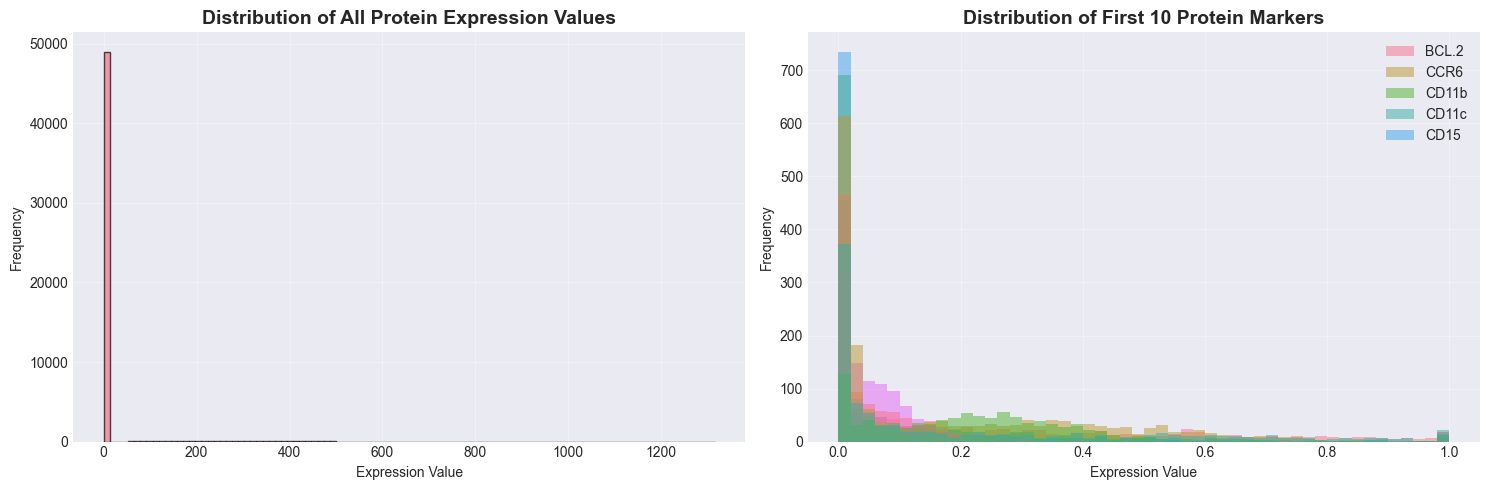


💡 Interpretation:
  - Protein expression values vary across different markers
  - Some markers have high expression (bright cells), others low
  - This heterogeneity is why normalization is crucial!


In [15]:
# Distribution of protein expression values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(train_sample[marker_cols].values.flatten(), bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of All Protein Expression Values', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Expression Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# Distribution of first 10 markers
for i, col in enumerate(marker_cols[:10]):
    axes[1].hist(train_sample[col], bins=50, alpha=0.5, label=col if i < 5 else '')
axes[1].set_title('Distribution of First 10 Protein Markers', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Expression Value')
axes[1].set_ylabel('Frequency')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  - Protein expression values vary across different markers")
print("  - Some markers have high expression (bright cells), others low")
print("  - This heterogeneity is why normalization is crucial!")

---
## 6. Cell Types & Markers <a id='celltypes'></a>

### Cell Types in Hodgkin Lymphoma (cHL CODEX Dataset)

Typical cell types found in lymph node tissue:

| Label | Cell Type | Description | Key Markers |
|-------|-----------|-------------|-------------|
| 0 | **T Cells (CD4+)** | Helper T cells | CD3+, CD4+, CD8- |
| 1 | **T Cells (CD8+)** | Cytotoxic T cells | CD3+, CD8+, CD4- |
| 2 | **B Cells** | Antibody-producing cells | CD20+, CD19+ |
| 3 | **Plasma Cells** | Mature B cells | CD138+, CD38+ |
| 4 | **Macrophages** | Immune cells that engulf pathogens | CD68+, CD163+ |
| 5 | **Dendritic Cells** | Antigen-presenting cells | CD11c+, HLA-DR+ |
| 6 | **NK Cells** | Natural Killer cells | CD56+, CD16+ |
| 7 | **Hodgkin Reed-Sternberg (HRS)** | **TUMOR CELLS** | CD30+, CD15+ |
| 8 | **Endothelial Cells** | Line blood vessels | CD31+, VWF+ |
| 9 | **Fibroblasts** | Connective tissue cells | Vimentin+, SMA+ |
| 10 | **Neutrophils** | Granulocytes | CD15+, MPO+ |
| 11 | **Other/Unclassified** | Ambiguous cells | - |

### Key Challenge: HRS Cell Detection
- HRS cells are **rare** (~1-5% of all cells)
- They are the **diagnostic hallmark** of Hodgkin Lymphoma
- They can be difficult to distinguish from reactive immune cells
- **Class imbalance** is a major challenge!

---
## 7. Train/Validation Split Strategy <a id='split'></a>

### Cross-Validation Approach

MAPS uses **5-fold stratified cross-validation**:

```
Fold 1: [Train: Regions 2-9] → [Test: Region 1]
Fold 2: [Train: Regions 1,3-9] → [Test: Region 2]
Fold 3: [Train: Regions 1-2,4-9] → [Test: Region 3]
Fold 4: [Train: Regions 1-3,5-9] → [Test: Region 4]
Fold 5: [Train: Regions 1-4,6-9] → [Test: Region 5]
```

### Why Stratified?
- **Maintains class distribution:** Each fold has similar proportions of cell types
- **Handles imbalance:** Ensures rare cell types (like HRS) appear in all folds
- **Robust evaluation:** Average metrics across 5 folds for reliable performance estimates

### Why This Matters for GNNs?
⚠️ **Critical Point:** If you're building Graph Neural Networks:
- DO NOT use random cell-level splitting!
- Use **region-based splitting** to prevent data leakage
- Test cells should never have edges to training cells

---
## 8. Data Statistics & Class Distribution <a id='stats'></a>

Understanding class imbalance is crucial for model training.

In [16]:
# Class distribution analysis
print("=" * 80)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

class_counts = train_sample['cell_label'].value_counts().sort_index()
class_percentages = (class_counts / len(train_sample) * 100)

# Create a summary table
dist_df = pd.DataFrame({
    'Cell Type': [f'Type {i}' for i in class_counts.index],
    'Count': class_counts.values,
    'Percentage': [f"{p:.2f}%" for p in class_percentages.values]
})
display(dist_df)

print("\nImbalance Metrics:")
print(f"  Most common class: Type {class_counts.idxmax()} ({class_counts.max()} cells, {class_percentages.max():.2f}%)")
print(f"  Least common class: Type {class_counts.idxmin()} ({class_counts.min()} cells, {class_percentages.min():.2f}%)")
print(f"  Imbalance ratio: {class_counts.max() / class_counts.min():.2f}:1")

CLASS DISTRIBUTION ANALYSIS


,Cell Type,Count,Percentage
0,Type 0,201,20.10%
1,Type 1,251,25.10%
2,Type 2,133,13.30%
3,Type 3,88,8.80%
4,Type 4,47,4.70%
5,Type 5,6,0.60%
6,Type 6,22,2.20%
7,Type 7,28,2.80%
8,Type 8,16,1.60%
9,Type 9,15,1.50%



Imbalance Metrics:
  Most common class: Type 1 (251 cells, 25.10%)
  Least common class: Type 5 (6 cells, 0.60%)
  Imbalance ratio: 41.83:1


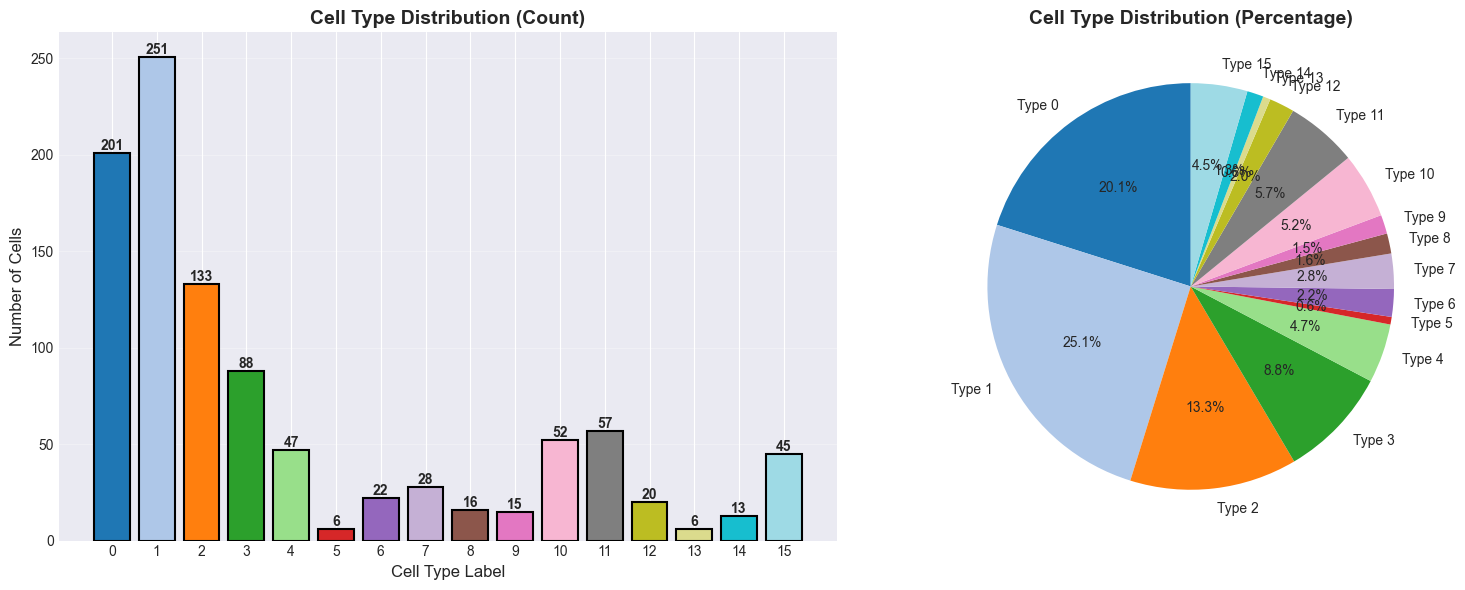


💡 Key Observations:
  - Class imbalance is present in the dataset
  - MAPS handles this with WeightedRandomSampler during training
  - This ensures the model learns all cell types equally


In [17]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = plt.cm.tab20(np.linspace(0, 1, len(class_counts)))
axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Cell Type Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cell Type Label', fontsize=12)
axes[0].set_ylabel('Number of Cells', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticks(class_counts.index)

# Add count labels on bars
for i, (idx, val) in enumerate(class_counts.items()):
    axes[0].text(idx, val, f'{val}', ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=[f'Type {i}' for i in class_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Cell Type Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("  - Class imbalance is present in the dataset")
print("  - MAPS handles this with WeightedRandomSampler during training")
print("  - This ensures the model learns all cell types equally")

---
## 9. Visualization <a id='viz'></a>

### Correlation Between Markers

Some proteins are co-expressed (positively correlated), while others are mutually exclusive (negatively correlated).

Computing correlation matrix for 20 markers...


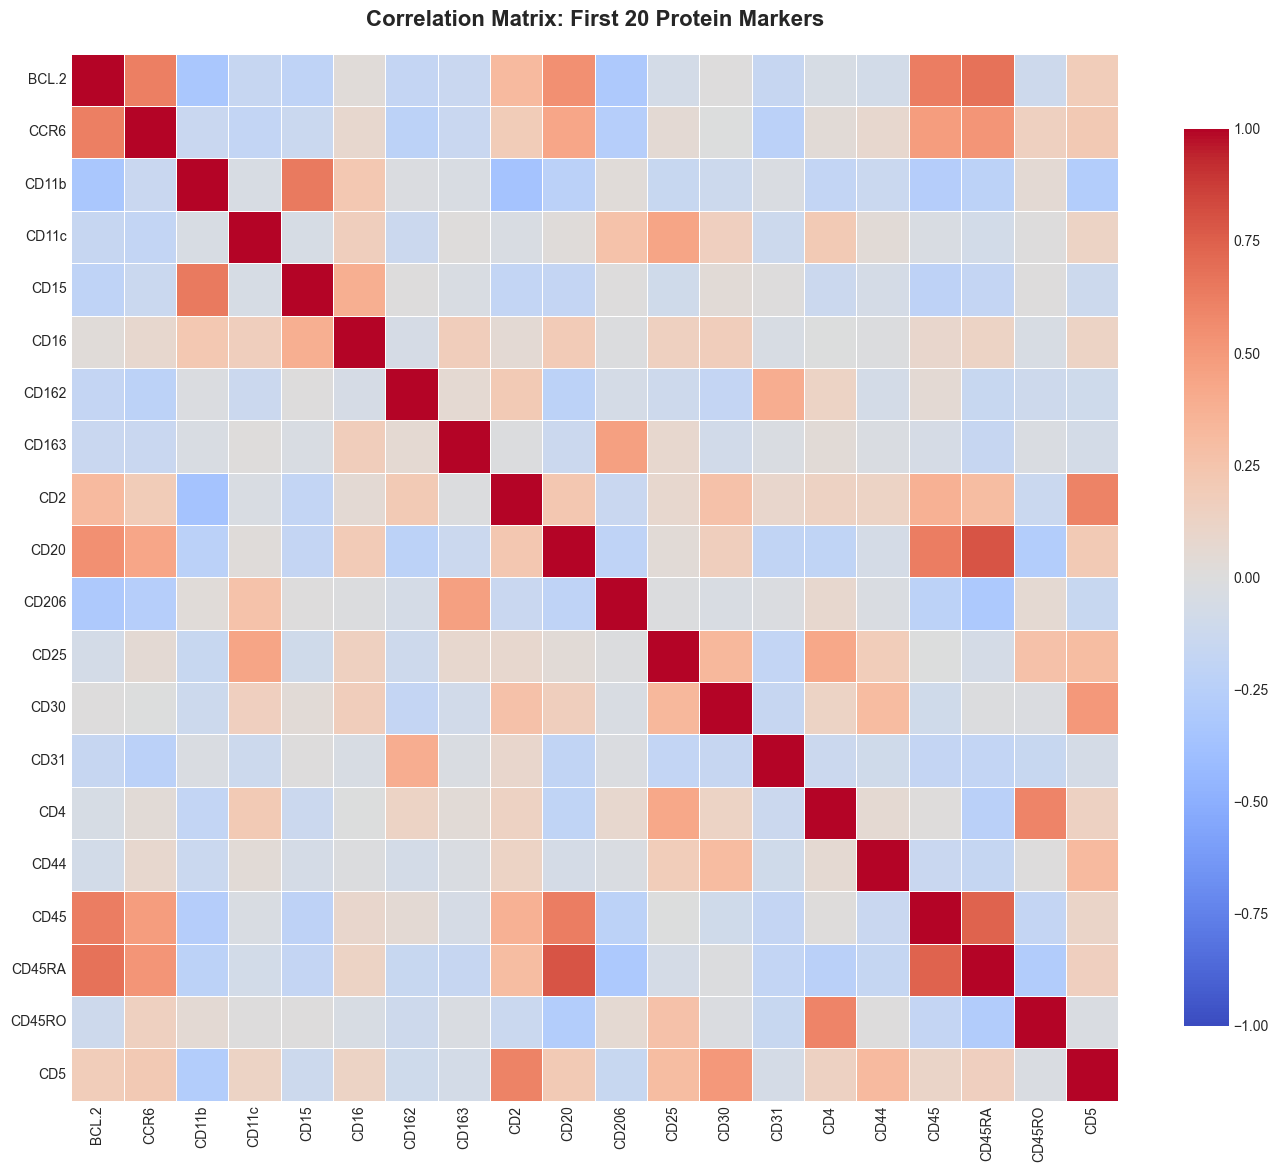


💡 Interpretation:
  - Red: Positive correlation (proteins co-expressed)
  - Blue: Negative correlation (mutually exclusive expression)
  - White: No correlation
  Example: CD3 and CD4 are often correlated (both T-cell markers)


In [18]:
# Compute correlation matrix for a subset of markers
n_markers_to_show = 20  # Show first 20 markers for clarity
subset_markers = marker_cols[:n_markers_to_show]

print(f"Computing correlation matrix for {n_markers_to_show} markers...")
corr_matrix = train_sample[subset_markers].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title(f'Correlation Matrix: First {n_markers_to_show} Protein Markers', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  - Red: Positive correlation (proteins co-expressed)")
print("  - Blue: Negative correlation (mutually exclusive expression)")
print("  - White: No correlation")
print("  Example: CD3 and CD4 are often correlated (both T-cell markers)")

In [19]:
# Find strongest correlations
# Get upper triangle of correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find top positive correlations
corr_pairs = corr_upper.stack().sort_values(ascending=False)

print("\nTop 10 Most Positively Correlated Marker Pairs:")
print("=" * 60)
for i, (pair, corr) in enumerate(corr_pairs.head(10).items(), 1):
    print(f"{i:2d}. {pair[0]:15s} ↔ {pair[1]:15s}  |  r = {corr:.3f}")

print("\nTop 10 Most Negatively Correlated Marker Pairs:")
print("=" * 60)
for i, (pair, corr) in enumerate(corr_pairs.tail(10).items(), 1):
    print(f"{i:2d}. {pair[0]:15s} ↔ {pair[1]:15s}  |  r = {corr:.3f}")


Top 10 Most Positively Correlated Marker Pairs:
 1. CD20            ↔ CD45RA           |  r = 0.795
 2. CD45            ↔ CD45RA           |  r = 0.742
 3. BCL.2           ↔ CD45RA           |  r = 0.675
 4. CD11b           ↔ CD15             |  r = 0.647
 5. CD20            ↔ CD45             |  r = 0.630
 6. BCL.2           ↔ CD45             |  r = 0.627
 7. BCL.2           ↔ CCR6             |  r = 0.623
 8. CD2             ↔ CD5              |  r = 0.609
 9. CD4             ↔ CD45RO           |  r = 0.601
10. BCL.2           ↔ CD20             |  r = 0.543

Top 10 Most Negatively Correlated Marker Pairs:
 1. CD4             ↔ CD45RA           |  r = -0.235
 2. CCR6            ↔ CD206            |  r = -0.265
 3. CD11b           ↔ CD45             |  r = -0.269
 4. CD20            ↔ CD45RO           |  r = -0.276
 5. CD11b           ↔ CD5              |  r = -0.281
 6. CD45RA          ↔ CD45RO           |  r = -0.286
 7. BCL.2           ↔ CD206            |  r = -0.308
 8. CD206  

### Feature Importance via Variance

Markers with higher variance across cells are more informative for classification.

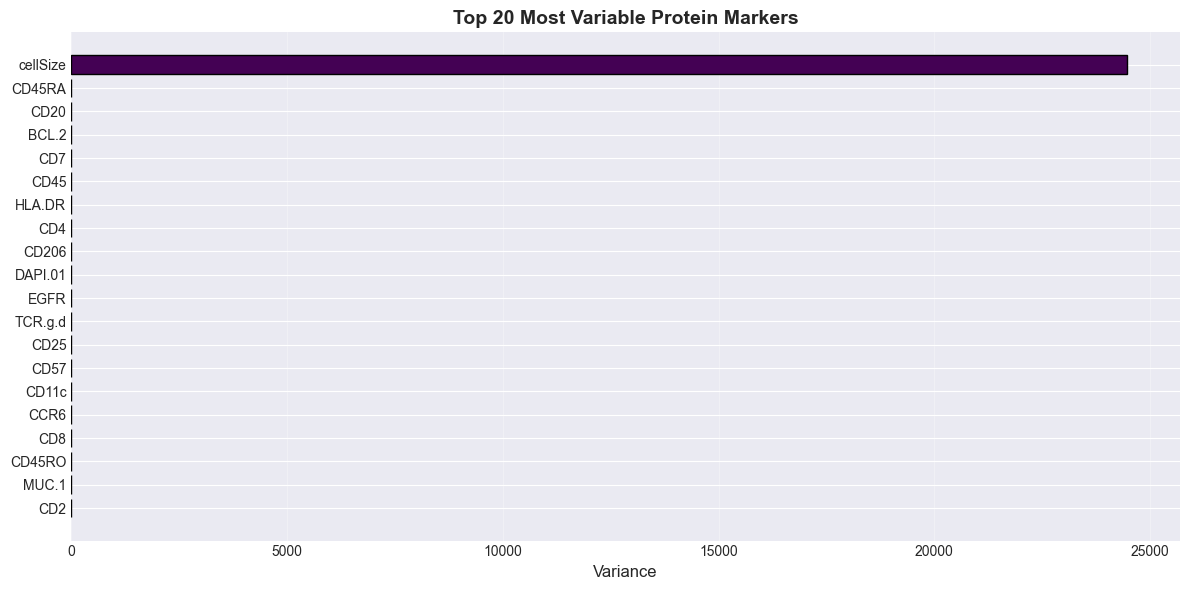


💡 Why Variance Matters:
  - High variance = marker varies a lot between cells
  - More likely to be discriminative for cell type classification
  - Low variance markers might be less informative


In [20]:
# Calculate variance for each marker
marker_variance = train_sample[marker_cols].var().sort_values(ascending=False)

# Plot top 20 most variable markers
plt.figure(figsize=(12, 6))
top_20_var = marker_variance.head(20)
colors_gradient = plt.cm.viridis(np.linspace(0, 1, 20))
plt.barh(range(20), top_20_var.values[::-1], color=colors_gradient[::-1], edgecolor='black')
plt.yticks(range(20), top_20_var.index[::-1])
plt.xlabel('Variance', fontsize=12)
plt.title('Top 20 Most Variable Protein Markers', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Why Variance Matters:")
print("  - High variance = marker varies a lot between cells")
print("  - More likely to be discriminative for cell type classification")
print("  - Low variance markers might be less informative")

### Cell Type Specific Expression Patterns

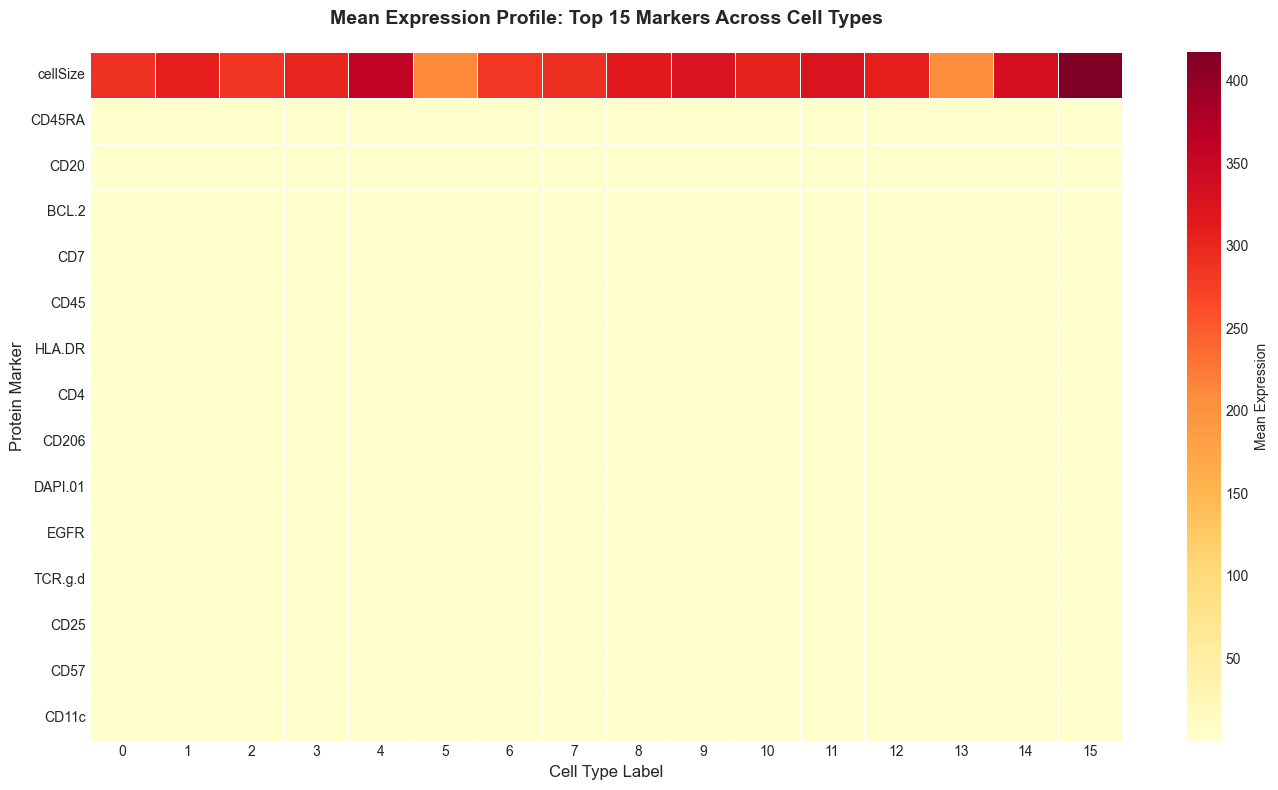


💡 This heatmap shows:
  - Each column = one cell type
  - Each row = one protein marker
  - Bright colors = high average expression in that cell type
  - Dark colors = low expression
  - Distinct patterns help the MLP learn to classify cells!


In [21]:
# For each cell type, compute mean expression of top markers
n_top_markers = 15
top_markers = marker_variance.head(n_top_markers).index.tolist()

# Compute mean expression per cell type
cell_type_profiles = train_sample.groupby('cell_label')[top_markers].mean()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cell_type_profiles.T, cmap='YlOrRd', cbar_kws={'label': 'Mean Expression'},
            linewidths=0.5, annot=False)
plt.xlabel('Cell Type Label', fontsize=12)
plt.ylabel('Protein Marker', fontsize=12)
plt.title(f'Mean Expression Profile: Top {n_top_markers} Markers Across Cell Types', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 This heatmap shows:")
print("  - Each column = one cell type")
print("  - Each row = one protein marker")
print("  - Bright colors = high average expression in that cell type")
print("  - Dark colors = low expression")
print("  - Distinct patterns help the MLP learn to classify cells!")

---
## 10. Key Insights & Challenges <a id='insights'></a>

### ✅ Dataset Strengths

1. **High-quality annotations:** Expert pathologist labels ensure ground truth accuracy
2. **Rich feature space:** 40-50+ protein markers provide comprehensive cell signatures
3. **Multiple datasets:** Cross-validation on different diseases/technologies
4. **Spatial context preserved:** X,Y coordinates available (though MAPS doesn't use them)

### ⚠️ Challenges

1. **Class Imbalance**
   - Rare cell types (HRS cells: ~1-5%)
   - Common cell types (T cells: ~30-40%)
   - Solution: WeightedRandomSampler

2. **High Dimensionality**
   - 40-50 features per cell
   - Risk of overfitting
   - Solution: Dropout, regularization

3. **Ambiguous Cells**
   - Some cells have overlapping marker expression
   - Inter-pathologist disagreement possible
   - Solution: Ensemble methods, GNNs for spatial context

4. **Spatial Context Ignored (in MAPS)**
   - MAPS treats cells independently
   - **YOUR RESEARCH OPPORTUNITY:** Use GNNs to leverage neighborhood!

### 🎯 Research Opportunities

#### Current MAPS Approach:
```
Input: [Marker_1, Marker_2, ..., Marker_47]
       ↓
   4-Layer MLP
       ↓
Output: Cell Type Probability
```

#### Your GNN Approach:
```
Input: [Marker_1, ..., Marker_47, X, Y]
       ↓
Build KNN Graph (spatial neighbors)
       ↓
GCN/GraphSAGE (aggregate neighbor info)
       ↓
Output: Cell Type Probability
```

**Hypothesis:** GNNs will outperform MLP by using spatial context!

**Example:** A cell with ambiguous markers inside a germinal center (surrounded by B-cells) is more likely to be a B-cell itself.

---

### 📊 Expected Performance

Based on the MAPS paper:
- **MAPS (MLP):** ~90% F1 score on cHL CODEX
- **ASTIR:** ~85% F1 score
- **CellSighter:** ~88% F1 score

**Your Goal:** Beat 90% F1 by incorporating spatial features with GNNs!

---

### 🔬 Next Steps

1. **Load actual cHL_CODEX annotations** (with X,Y coordinates)
2. **Build KNN graphs** from spatial locations
3. **Implement GNN models** (GCN, GraphSAGE)
4. **Use NeighborLoader** for memory-efficient training
5. **Compare:** MLP vs GCN vs GraphSAGE
6. **Analyze errors:** Where does spatial context help most?

---

## Summary

### What We Learned:

✅ **Data Structure:** CSV files with protein marker columns + cell_label  
✅ **Scale:** 100K+ cells per dataset, 40-50 protein markers  
✅ **Cell Types:** 10-12 different types (immune cells, tumor cells, stromal cells)  
✅ **Challenge:** Class imbalance, high dimensionality  
✅ **MAPS Baseline:** 4-layer MLP, ~90% F1 score  
✅ **Research Gap:** Spatial context not used → opportunity for GNNs!  

### Files You Need:
- `data/cell_phenotyping/train.csv` - Training data
- `data/cell_phenotyping/valid.csv` - Validation data
- `cHL_CODEX/annotation_csv/` - Annotations with spatial coordinates

### Ready for Your GNN Experiment!
Now you understand the data structure and can proceed to build your Graph Neural Network model! 🚀

In [22]:
# Save summary statistics for reference
summary_stats = {
    'n_cells': len(train_sample),
    'n_markers': len(marker_cols),
    'n_classes': train_sample['cell_label'].nunique(),
    'class_distribution': class_counts.to_dict(),
    'imbalance_ratio': float(class_counts.max() / class_counts.min()),
    'marker_variance_top10': marker_variance.head(10).to_dict()
}

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
for key, value in summary_stats.items():
    if isinstance(value, dict) and len(value) > 5:
        print(f"{key}: {len(value)} items")
    else:
        print(f"{key}: {value}")
print("="*80)


DATASET SUMMARY
n_cells: 1000
n_markers: 50
n_classes: 16
class_distribution: 16 items
imbalance_ratio: 41.833333333333336
marker_variance_top10: 10 items
